### Introduction

One of the most important variables in various transportation models is the travel time estimates by different modes of transport. Traditionally, this information is provided by the regional travel demand model in the form of Highway Skims and Transit Skims. The highway skims contain driving time from one zone (usually TAZ) to another via the transportation network, while the transit skims contain detailed information about transit travel times from one zone to another.

This data is not public and is difficult for students and researchers to access.

This code provides an open-source code for retrieving this information from Google Maps Directions API. Any interested student or researcher or analyst can retrieve travel times for any origin-destination pair using this code.

The shapefile used for this example is also publicly available. It is the block groups shapefile for the State of Connecticut, but the code can be used on any other shapefiles representing other locations and geographic units (census tracts, TAZ etc.).

### Import Libraries

In [1]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import Polygon
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import timeit

import googlemaps

pylab.rcParams['figure.figsize'] = 10, 8

import warnings 
warnings.filterwarnings('ignore')

### Read Shapefiles

In [3]:
blocks = gpd.read_file('./blockgroupct_37800_0000_2010_s100_census_1_shp_wgs84.shp')

In [4]:
blocks.crs

{'init': u'epsg:4326'}

In [5]:
blocks.crs = {'init' :'epsg:4326'}

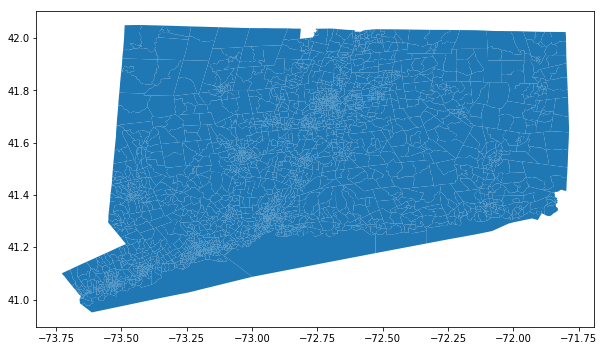

In [6]:
blocks.plot();

In [7]:
blocks['GEOID10'].nunique()

2585

### Get Latitude and Longitude of Block Group Centroids

In [8]:
blocks["longitude"] = blocks.centroid.map(lambda p: p.x)
blocks["latitude"] = blocks.centroid.map(lambda p: p.y)

In [9]:
blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,GEOID_AFF2,geometry,longitude,latitude
0,09,001,043600,2,090010436002,Block Group 2,G5030,S,515035,61927,+41.1123563,-073.4058517,1500000US090010436002,POLYGON ((-73.40618213007664 41.10853033732734...,-73.405139,41.111601
1,09,001,043700,1,090010437001,Block Group 1,G5030,S,587493,0,+41.1173900,-073.4146092,1500000US090010437001,POLYGON ((-73.41617213395659 41.11991833923131...,-73.414610,41.117398
2,09,001,043700,2,090010437002,Block Group 2,G5030,S,592739,59242,+41.1119648,-073.4143835,1500000US090010437002,POLYGON ((-73.41928013420153 41.10665033653035...,-73.413860,41.111611
3,09,001,043800,3,090010438003,Block Group 3,G5030,S,303298,0,+41.1099381,-073.4221286,1500000US090010438003,POLYGON ((-73.42308513541818 41.10642633636188...,-73.422130,41.109946
4,09,001,043800,5,090010438005,Block Group 5,G5030,S,282924,0,+41.1083246,-073.4304149,1500000US090010438005,POLYGON ((-73.43399913914945 41.11000333670524...,-73.430416,41.108333


### Select 30 Origins and 30 Destinations Randomly

In [10]:
origins = blocks.sample(30, random_state = 5)
destinations = blocks.sample(30, random_state = 10)

In [11]:
origins = origins[['GEOID10', 'latitude', 'longitude']]
destinations = destinations[['GEOID10', 'latitude', 'longitude']]

In [12]:
origins.reset_index(inplace=True)
destinations.reset_index(inplace=True)

In [13]:
origins.dtypes

index          int64
GEOID10       object
latitude     float64
longitude    float64
dtype: object

In [14]:
data = pd.concat([origins, destinations], axis=1)

In [15]:
data[:2]

,index,GEOID10,latitude,longitude,index,GEOID10,latitude,longitude
0,734,090010743003,41.180517,-73.162560,608,090010503004,41.149937,-73.336621
1,1794,090075412001,41.580064,-72.668897,1787,090076401002,41.412045,-72.584738


In [16]:
data.drop(data.columns[0], axis = 1, inplace=True)

In [17]:
data.shape

(30, 6)

In [18]:
data.columns = ['O_GEOID10', 'o_lat', 'o_lng', 'D_GEOID10', 'd_lat', 'd_lng']

In [19]:
data.head()

,O_GEOID10,o_lat,o_lng,D_GEOID10,d_lat,d_lng
0,090010743003,41.180517,-73.162560,090010503004,41.149937,-73.336621
1,090075412001,41.580064,-72.668897,090076401002,41.412045,-72.584738
2,090053104001,41.800013,-73.108560,090091673003,41.346277,-72.852424
3,090091716003,41.551086,-72.800155,090159011005,41.928442,-71.944603
4,090010903002,41.236985,-73.225568,090053102001,41.806751,-73.123648


In [20]:
driving_data = data
transit_data = data

## Google Maps

In [21]:
gmaps = googlemaps.Client(key = 'INSERT YOUR KEY HERE')

### Retrieve Auto (Driving) Travel Time

In [22]:
cols = ['driving_distance', 'driving_duration']

for col in cols:
    driving_data[col] = 0.0

In [23]:
start_time = timeit.default_timer()

driving_results = []

for index, row in driving_data.iterrows():
    x1 = row['o_lat']
    y1 = row['o_lng']
    x2 = row['d_lat']
    y2 = row['d_lng']
    
    directions_result = (gmaps.directions(origin = (x1,y1), destination = (x2,y2), mode="driving"))
    
    driving_results.append(directions_result)

    
    dist_meter = (directions_result[0]['legs'][0]['distance']['value'])
    driving_data.set_value(index, 'driving_distance', dist_meter/1609.34)
    
    duration_sec = (directions_result[0]['legs'][0]['duration']['value'])
    driving_data.set_value(index, 'driving_duration', duration_sec/60.0)
    
    
elapsed = timeit.default_timer() - start_time
print 'Time taken to execute this code was %f seconds' %elapsed

Time taken to execute this code was 6.548237 seconds


In [24]:
driving_data

,O_GEOID10,o_lat,o_lng,D_GEOID10,d_lat,d_lng,driving_distance,driving_duration
0,090010743003,41.180517,-73.162560,090010503004,41.149937,-73.336621,13.197336,18.783333
1,090075412001,41.580064,-72.668897,090076401002,41.412045,-72.584738,15.779139,23.833333
2,090053104001,41.800013,-73.108560,090091673003,41.346277,-72.852424,52.732176,54.316667
3,090091716003,41.551086,-72.800155,090159011005,41.928442,-71.944603,65.847490,72.650000
4,090010903002,41.236985,-73.225568,090053102001,41.806751,-73.123648,49.203400,51.916667
5,090091405002,41.292307,-72.943230,090091714002,41.534497,-72.787740,22.852225,27.650000
6,090117141042,41.547670,-72.277201,090091546003,41.272598,-72.954420,55.868244,64.500000
7,090054254003,41.639852,-73.036599,090116952014,41.448390,-72.131222,70.758820,81.716667
8,090091752002,41.453754,-72.825710,090012453002,41.275842,-73.462376,48.194291,61.300000
9,090159045003,41.806270,-71.879841,090053621021,41.593295,-73.185942,89.844905,107.316667


### Retrieve Transit Travel Time

In [25]:
transit_cols = ['transit_total_distance', 'transit_total_duration', 'transfers', 'access_distance', 'access_duration', 'egress_distance', 'egress_duration']

for col in transit_cols:
    transit_data[col] = 0.0

In [26]:
start_time = timeit.default_timer()

transit_results = []

for index, row in transit_data.iterrows():
    x1 = row['o_lat']
    y1 = row['o_lng']
    x2 = row['d_lat']
    y2 = row['d_lng']
    
    directions_result = (gmaps.directions(origin = (x1,y1), destination = (x2,y2), mode="transit"))
    
    transit_results.append(directions_result)
    
    if len(directions_result) == 0:
        for col in transit_cols:
            transit_data.set_value(index, col, -99)
        continue
    
    dist_meter = (directions_result[0]['legs'][0]['distance']['value'])
    transit_data.set_value(index, 'transit_total_distance', dist_meter/1609.34)
    
    duration_sec = (directions_result[0]['legs'][0]['duration']['value'])
    transit_data.set_value(index, 'transit_total_duration', duration_sec/60.0)
    
    trans = pd.DataFrame(directions_result[0]['legs'][0]['steps'])
    transfers = (np.sum(trans['travel_mode'] == 'TRANSIT') - 1)
    transit_data.set_value(index, 'transfers', transfers)
    
    steps = len(directions_result[0]['legs'][0]['steps'])
    
    if steps == 1:
        transit_data.set_value(index, 'access_distance', -99)
        transit_data.set_value(index, 'access_duration', -99)
        transit_data.set_value(index, 'egress_distance', -99)
        transit_data.set_value(index, 'egress_duration', -99)
        continue
    
    if (directions_result[0]['legs'][0]['steps'][0]['travel_mode']) == 'WALKING':
    
        acc_dist_meter = (directions_result[0]['legs'][0]['steps'][0]['distance']['value'])
        transit_data.set_value(index, 'access_distance', round((acc_dist_meter/1609.34),2))

        acc_duration_sec = (directions_result[0]['legs'][0]['steps'][0]['duration']['value'])
        transit_data.set_value(index, 'access_duration', round((acc_duration_sec/60.0), 2))
        
    else:
        transit_data.set_value(index, 'access_distance', -99)
        transit_data.set_value(index, 'access_duration', -99)
        
    if (directions_result[0]['legs'][0]['steps'][steps-1]['travel_mode']) == 'WALKING':
    
        egr_dist_meter = (directions_result[0]['legs'][0]['steps'][steps - 1]['distance']['value'])
        transit_data.set_value(index, 'egress_distance', round((egr_dist_meter/1609.34), 2))

        egr_duration_sec = (directions_result[0]['legs'][0]['steps'][steps - 1]['duration']['value'])
        transit_data.set_value(index, 'egress_duration', round((egr_duration_sec/60.0), 2))
        
    else:
        transit_data.set_value(index, 'egress_distance', -99)
        transit_data.set_value(index, 'egress_duration', -99)

elapsed = timeit.default_timer() - start_time
print 'Time taken to execute this code was %f seconds' %elapsed

Time taken to execute this code was 4.561691 seconds


In [27]:
transit_data

,O_GEOID10,o_lat,o_lng,D_GEOID10,d_lat,d_lng,driving_distance,driving_duration,transit_total_distance,transit_total_duration,transfers,access_distance,access_duration,egress_distance,egress_duration
0,090010743003,41.180517,-73.162560,090010503004,41.149937,-73.336621,13.197336,18.783333,12.401357,69.833333,0.0,0.07,1.33,1.04,21.35
1,090075412001,41.580064,-72.668897,090076401002,41.412045,-72.584738,15.779139,23.833333,-99.000000,-99.000000,-99.0,-99.00,-99.00,-99.00,-99.00
2,090053104001,41.800013,-73.108560,090091673003,41.346277,-72.852424,52.732176,54.316667,52.264282,204.833333,2.0,0.64,12.55,0.78,16.98
3,090091716003,41.551086,-72.800155,090159011005,41.928442,-71.944603,65.847490,72.650000,-99.000000,-99.000000,-99.0,-99.00,-99.00,-99.00,-99.00
4,090010903002,41.236985,-73.225568,090053102001,41.806751,-73.123648,49.203400,51.916667,58.386668,191.916667,2.0,1.00,20.43,0.56,12.02
5,090091405002,41.292307,-72.943230,090091714002,41.534497,-72.787740,22.852225,27.650000,24.263363,101.750000,1.0,-99.00,-99.00,0.42,9.55
6,090117141042,41.547670,-72.277201,090091546003,41.272598,-72.954420,55.868244,64.500000,-99.000000,-99.000000,-99.0,-99.00,-99.00,-99.00,-99.00
7,090054254003,41.639852,-73.036599,090116952014,41.448390,-72.131222,70.758820,81.716667,-99.000000,-99.000000,-99.0,-99.00,-99.00,-99.00,-99.00
8,090091752002,41.453754,-72.825710,090012453002,41.275842,-73.462376,48.194291,61.300000,-99.000000,-99.000000,-99.0,-99.00,-99.00,-99.00,-99.00
9,090159045003,41.806270,-71.879841,090053621021,41.593295,-73.185942,89.844905,107.316667,-99.000000,-99.000000,-99.0,-99.00,-99.00,-99.00,-99.00
